#Data Import

In [ ]:
# @title Install dependencies
!pip install nilearn --quiet

import os
import re
import tarfile
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

#print(np.__version__)
#print(pd.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 65.8 MB/s eta 0:00:00


# Parameter and Data download

In [ ]:
# parameter setting
N_SUBJECTS = 100
N_PARCELS = 360 # Data aggregated into ROIs from Glasser parcellation
TR = 0.72  # Time resolution, in seconds
HEMIS = ["Right", "Left"]
RUNS   = ["LR","RL"]
N_RUNS = 2

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools',
                            '2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

TargetExperiments = ['WM', 'EMOTION', 'LANGUAGE']

TargetConditions  = ["0bk_body", "0bk_faces", "0bk_places", "0bk_tools",
                     "2bk_body", "2bk_faces", "2bk_places", "2bk_tools",
                     "fear"    , "neut"     , "math"      , "story"    ]

# Data download
fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("Download FAILED: Connection Error!")
  else:
    if r.status_code != requests.codes.ok:
      print("Download FAILED!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)


HCP_DIR = "./hcp_task"

with tarfile.open(fname) as tfile:
  tfile.extractall('.')

SubjectIDs = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')
SubjectIDs = list(SubjectIDs)

# Regions and parcels

In [ ]:
### doc about the regions file will be inserted (look at regions.npy)

regions = np.load(f"{HCP_DIR}/regions.npy").T

region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)


### code will be updated

{'name': ['R_V1', 'R_MST', 'R_V6', 'R_V2', 'R_V3', 'R_V4', 'R_V8', 'R_4', 'R_3b', 'R_FEF', 'R_PEF', 'R_55b', 'R_V3A', 'R_RSC', 'R_POS2', 'R_V7', 'R_IPS1', 'R_FFC', 'R_V3B', 'R_LO1', 'R_LO2', 'R_PIT', 'R_MT', 'R_A1', 'R_PSL', 'R_SFL', 'R_PCV', 'R_STV', 'R_7Pm', 'R_7m', 'R_POS1', 'R_23d', 'R_v23ab', 'R_d23ab', 'R_31pv', 'R_5m', 'R_5mv', 'R_23c', 'R_5L', 'R_24dd', 'R_24dv', 'R_7AL', 'R_SCEF', 'R_6ma', 'R_7Am', 'R_7PL', 'R_7PC', 'R_LIPv', 'R_VIP', 'R_MIP', 'R_1', 'R_2', 'R_3a', 'R_6d', 'R_6mp', 'R_6v', 'R_p24pr', 'R_33pr', 'R_a24pr', 'R_p32pr', 'R_a24', 'R_d32', 'R_8BM', 'R_p32', 'R_10r', 'R_47m', 'R_8Av', 'R_8Ad', 'R_9m', 'R_8BL', 'R_9p', 'R_10d', 'R_8C', 'R_44', 'R_45', 'R_47l', 'R_a47r', 'R_6r', 'R_IFJa', 'R_IFJp', 'R_IFSp', 'R_IFSa', 'R_p9-46v', 'R_46', 'R_a9-46v', 'R_9-46d', 'R_9a', 'R_10v', 'R_a10p', 'R_10pp', 'R_11l', 'R_13l', 'R_OFC', 'R_47s', 'R_LIPd', 'R_6a', 'R_i6-8', 'R_s6-8', 'R_43', 'R_OP4', 'R_OP1', 'R_OP2-3', 'R_52', 'R_RI', 'R_PFcm', 'R_PoI2', 'R_TA2', 'R_FOP4', 'R_MI', 'R

# Helper functions (e.g. load time series and evs)


In [ ]:
# load time series
def load_single_timeseries(subject, experiment, run, remove_mean=True):
    """Load timeseries data for a single subject and single run.

    Arguments:
        subject (str):      subject ID to load
        experiment (str):   Name of experiment
        run (int):          (0 or 1)
        remove_mean (bool): If True, subtract the parcel-wise mean
                            (typically the mean BOLD signal is not of interest)

    Returns
        ts (n_parcel x n_timepoint array): Array of BOLD data values

    """
    bold_run  = RUNS[run]
    bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
    bold_file = "data.npy"
    ts_path   = f"{bold_path}/{bold_file}"

    if not os.path.exists(ts_path):
        raise FileNotFoundError(f"Timeseries file not found: {ts_path}")
    ts = np.load(ts_path)

    if remove_mean:
        ts = ts - ts.mean(axis=1, keepdims=True)
    return ts

In [ ]:
# load evs
def load_evs(subject, experiment, run):
    """Load EVs (explanatory variables) data for one task experiment.

    Arguments:
        subject (str): subject ID to load
        experiment (str): Name of experiment
        run (int): 0 or 1

    Returns:
        evs (list of lists): A list of frames associated with each condition

    """
    frames_list = []
    task_key = f"tfMRI_{experiment}_{RUNS[run]}"
    for cond in EXPERIMENTS[experiment]["cond"]:
        ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))

        # Determine when trial starts, rounded down
        start = np.floor(ev["onset"] / TR).astype(int)
        # Use trial duration to determine how many frames to include for trial
        duration = np.ceil(ev["duration"] / TR).astype(int)
        # Take the range of frames that correspond to this specific trial
        frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
        frames_list.append(frames)

    return frames_list


def load_evs_as_dict(subject, experiment, run):
    """Load EVs (explanatory variables) data for one task experiment.

    Arguments:
        subject (str): subject ID to load
        experiment (str): Name of experiment
        run (int): 0 or 1

    Returns:
        evs (dict): A dictionary of the data associated with each condition

    """
    evs = {}
    task_key = f"tfMRI_{experiment}_{RUNS[run]}"

    for cond  in EXPERIMENTS[experiment]["cond"]:
        ev_file = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
        if not os.path.exists(ev_file):
            raise FileNotFoundError(f"EV file not found: {ev_file}")
        ev_array  = np.loadtxt(ev_file, ndmin=2, unpack=True)
        evs[cond] = dict(zip(["onset", "duration", "amplitude"], ev_array))

    return evs

In [ ]:
# create data frame
def create_dataframe(subject, experiment):
    """
    Creates a dataframe that contains the parcel-based
    BOLD signals from a subject for each condition.

    Arguments:
        subject (str): subject ID to load
        experiment (str): Name of experiment

    Returns:
        A dataframe of parcel-based BOLD data
        for one subject and one experiment

    """
    all_data = []

    for run in range(2): # Run can be 0 (LR) or 1 (RL)
        try:
            ts  = load_single_timeseries(subject, experiment, run)
            evs = load_evs_as_dict(subject, experiment, run)
        except FileNotFoundError as e:
            print(e)
            continue

        n_parcels, n_timepoints = ts.shape

        for condition, ev_data in evs.items():
            onset_times = ev_data["onset"]
            durations   = ev_data["duration"]
            amplitudes  = ev_data["amplitude"]

            for onset, duration, amplitude in zip(onset_times, durations, amplitudes):
                start_frame = int(onset / TR)
                end_frame   = start_frame + int(duration / TR)

                for time_point in range(start_frame, end_frame):
                    if time_point < n_timepoints: # Ensure it is within bounds
                        row = {
                            "sunject"      : subject   ,
                            "experiment"   : experiment,
                            "run"          : RUNS[run] ,
                            "condition"    : condition ,
                            "timepoint"    : time_point,
                            "EV_onset"     : onset     ,
                            "EV_duration"  : duration  ,
                            "EV_amplitude" : amplitude
                        }
                        # Add BOLD signal data for all parcels
                        row.update({f"parcel_{i}": ts[i, time_point] for i in range(n_parcels)})
                        all_data.append(row)

    df = pd.DataFrame(all_data)
    return df

In [ ]:
def extract_stats(subject, experiment):
    """Aggregates all data for a subject into
    a dictionary that can be used along with
    "gather_all_subjects_stats()" to create
    the final dataframe.

    Arguments:
        subjects    (list of str): list of SubjectIDs
        experiments (list of str): list of TargetExperiments

    Returns:
        A dictionary of all the data points
        for a subject's specific experiment.


    """
    stats_dict = {"subject": subject}
    task_path  = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_LR/EVs"

    if os.path.exists(task_path):
        for filename in os.listdir(task_path):
            if filename == "Stats.txt":
                filepath = os.path.join(task_path, filename)
                with open(filepath, "r") as file:
                    lines = file.readlines()
                    for line in lines:
                        match = re.match(r"([\w\s-]+): ([\d.]+)", line.strip())
                        if match:
                            key, value = match.groups()
                            stats_dict[f"{experiment}_{key.strip().replace(' ', '_')}"] = float(value)

    return stats_dict

In [ ]:
def gather_all_subjects_stats(subjects, experiments):
    """Creates a dataframe containing all data from
    all subjects which stores the parcel-based BOLD signals.

    Arguments:
        subjects    (list of str): list of SubjectIDs
        experiments (list of str): list of TargetExperiments

    Returns:
        A dataframe of parcel-based BOLD data
        for all subjects and all experiments

    """
    all_stats = []

    for subject in subjects:
        subject_stats = {"subject": subject}
        for experiment in experiments:
            stats = extract_stats(subject, experiment)
            subject_stats.update(stats)

            # Get the dimensions of DataFrame for this subject and experiment
            try:
                df = create_dataframe(subject, experiment)
                subject_stats[f"{experiment}_num_rows"] = df.shape[0]
                subject_stats[f"{experiment}_num_cols"] = df.shape[1]
            except FileNotFoundError:
                subject_stats[f"{experiment}_num_rows"] = None
                subject_stats[f"{experiment}_num_cols"] = None

        all_stats.append(subject_stats)

    stats_df = pd.DataFrame(all_stats)
    return stats_df

In [ ]:
def save_stats_to_csv(df, filename):
    """Saves the input dataframe as a csv in working directory.

    Arguments:
        df (dataframe)
        filename (str)
    """
    df.to_csv(filename, index=False)

In [ ]:
def save_to_csv(df, output_folder, filename):
    """Saves the input dataframe as a csv in
    output_folder of working directory.

    Arguments:
        df      (dataframe)
        output_folder (str)
        filename      (str)
    """
    file_path = os.path.join(output_folder, filename)
    df.to_csv(file_path, index=False)

In [ ]:
def process_subject(subject, experiments, output_folder):
    """
    ????????
    Works with create_dataframe() and save_tocsv() functions.

    Arguments:

    Returns:
        List of dataframes.
    """
    all_dfs = []

    for experiment in experiments:
        df = create_dataframe(subject, experiment)
        if not df.empty:
            all_dfs.append(df)
        else:
            print(f"No data to save for subject {subject}, experiment {experiment}.")

        # Concatenate all dataframes row-wise
        if all_dfs:
            final_df = pd.concat(all_dfs, axis = 0)
            save_to_csv(final_df, output_folder, f"{subject}_data.csv")
        else:
            print(f"No data to save for subject {subject}.")

    return

# Functions for the matrix construction and modeling  (TO BE ADDED!!!)

In [ ]:
# # load time series and ev from HCP data
subj_100307 = load_single_timeseries('100307', 'WM', 0, remove_mean = True)
print(subj_100307.shape)

subj_100307_ev = load_evs('100307','WM', 0)
print(subj_100307_ev)


(360, 405)
[[array([53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91])], [array([311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
       324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
       337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349])], [array([350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375,
       376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388])], [array([152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190])], [array([212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
       225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
  

# Create dataframes

In [ ]:
# create grand dataframe for all subjects
output_folder = "./output_csv_files"
os.makedirs(output_folder, exist_ok = True)

for subject in SubjectIDs:
    process_subject(subject, TargetExperiments, output_folder)

In [ ]:
file_list = os.listdir(output_folder)

for filename in file_list:
  filepath = os.path.join(output_folder, filename)
  df = pd.DataFrame()  # Create an empty dataframe
  df = pd.read_csv(filepath)  # Load data from CSV (overwrites the empty dataframe)
  # Perform your desired manipulations on the dataframe (df) here


# Preprocessing

In [ ]:
# preprocessing

#Regressors


In [ ]:
#@title create regressor
import nilearn
import nibabel as nib
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.signal import clean



# decide event or task based regressor (to confirm the delay in fMRI doesn't affect results)
# for event, check ev file

repetition time is 0.72 second
the acquisition comprises 405 scans


/usr/local/lib/python3.11/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:208: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:208: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:208: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


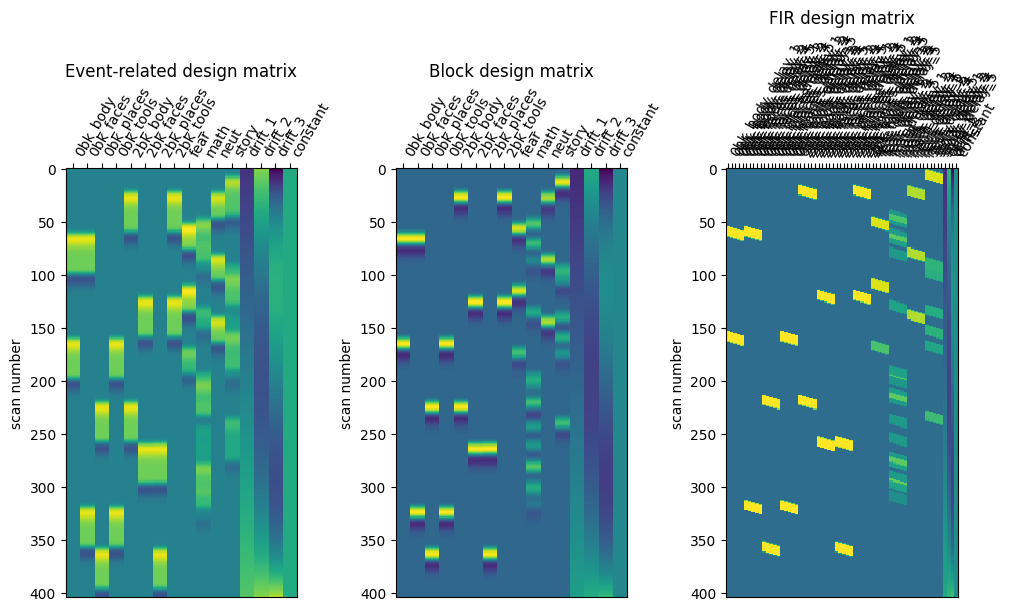

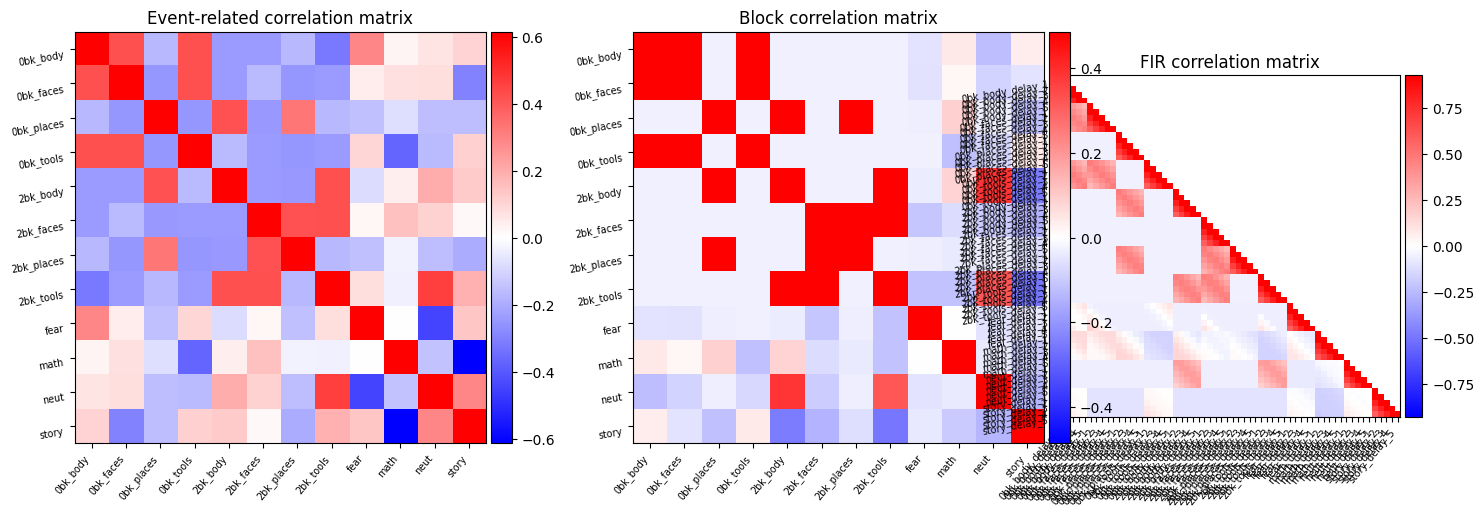

/usr/local/lib/python3.11/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:208: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


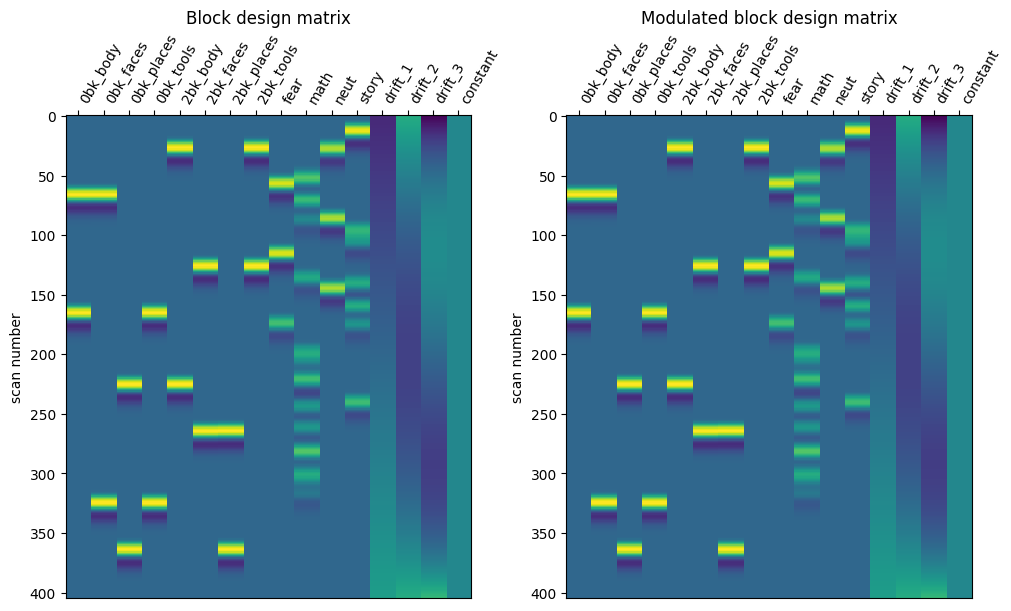

In [ ]:
# design matrix
"""
Examples of design matrices
===========================

Three examples of design matrices specification and computation for first-level
:term:`fMRI` data analysis (event-related design, block design,
:term:`FIR` design).

This examples requires matplotlib.

"""

# %%
# Define parameters
# -----------------
# At first, we define parameters related to the images acquisition.

t_r = 0.72 #.72 = data of one subject
### check where does 0.72 come from

n_scans = subj_100307.shape[1]

print(f"repetition time is {t_r} second")
print(f"the acquisition comprises {n_scans} scans")

frame_times = (
    np.arange(n_scans) * t_r
)  # here are the corresponding frame times

# %%
# Then we define parameters related to the experimental design.

# these are the types of the different trials
conditions = df['condition']
duration = df['EV_duration'] # fix this
# these are the corresponding onset times
onsets = df['EV_onset'] #range of this should match with "duration"
# Next, we simulate 6 motion parameters jointly observed with fMRI acquisitions
# rng = np.random.default_rng(42)
# motion = np.cumsum(rng.standard_normal((n_scans, 6)), 0)
# The 6 parameters correspond to three translations and three
# rotations describing rigid body motion
# add_reg_names = ["tx", "ty", "tz", "rx", "ry", "rz"] # Don't have motion data currently (Feb 13, 2025)

# %%
# Create design matrices
# ----------------------
# The same parameters allow us to obtain a variety of design matrices.
# We first create an events object.

events = pd.DataFrame(
    {"trial_type": conditions, "onset": onsets, "duration": duration}
)

# %%
# We sample the events into a design matrix,
# also including additional regressors.
from nilearn.glm.first_level import make_first_level_design_matrix

hrf_model = "glover"
X1 = make_first_level_design_matrix(
    frame_times,
    events,
    drift_model="polynomial",
    drift_order=3,
    # add_regs=motion,
    # add_reg_names=add_reg_names,
    # hrf_model=hrf_model,
)

# %%
# Now we compute a block design matrix. We add duration to create the blocks.
# For this we first define an event structure that includes the duration
# parameter.

duration = 7.0 * np.ones(len(conditions))
events = pd.DataFrame(
    {"trial_type": conditions, "onset": onsets, "duration": duration}
)

# %%
# Then we sample the design matrix.

X2 = make_first_level_design_matrix(
    frame_times,
    events,
    drift_model="polynomial",
    drift_order=3,
    hrf_model=hrf_model,
)

# %%
# Finally we compute a :term:`FIR` model

events = pd.DataFrame(
    {"trial_type": conditions, "onset": onsets, "duration": duration}
)
hrf_model = "FIR"
X3 = make_first_level_design_matrix(
    frame_times,
    events,
    hrf_model="fir",
    drift_model="polynomial",
    drift_order=3,
    fir_delays=np.arange(1, 6),
)

# %%
# Here are the three designs side by side.
#
# .. note::
#
#     The events with a duration of 0 seconds are be modeled
#     using a 'delta function' in the event-related design matrix.
#
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix

fig, (ax1, ax2, ax3) = plt.subplots(
    figsize=(10, 6), nrows=1, ncols=3, constrained_layout=True
)

plot_design_matrix(X1, axes=ax1)
ax1.set_title("Event-related design matrix", fontsize=12)
plot_design_matrix(X2, axes=ax2)
ax2.set_title("Block design matrix", fontsize=12)
plot_design_matrix(X3, axes=ax3)
ax3.set_title("FIR design matrix", fontsize=12)
plt.show()


# %%
# Correlation between regressors
# ------------------------------
# We can plot the correlation between the regressors of our design matrix.
# This is important to check as highly correlated regressors can affect
# the effficieny of
# `your design <https://imaging.mrc-cbu.cam.ac.uk/imaging/DesignEfficiency>`_.
#
from nilearn.plotting import plot_design_matrix_correlation

fig, (ax1, ax2, ax3) = plt.subplots(
    figsize=(16, 5), nrows=1, ncols=3, constrained_layout=True
)

plot_design_matrix_correlation(X1, axes=ax1)
ax1.set_title("Event-related correlation matrix", fontsize=12)
plot_design_matrix_correlation(X2, axes=ax2)
ax2.set_title("Block correlation matrix", fontsize=12)
plot_design_matrix_correlation(X3, axes=ax3, tri="diag")
ax3.set_title("FIR correlation matrix", fontsize=12)
plt.show()


# %%
# Parametric modulation
# ---------------------
# By default, the fMRI GLM will expect that all events
# for a given condition have a BOLD
# response with the same amplitude.
# Sometimes, we may have specific expectations
# about how strong the BOLD response
# will be on a given event.
# This can be incorporated into the model by using **parametric modulation**,
# wherein each event has a predicted amplitude.
# This can be used both to improve model fit and to test hypotheses regarding
# how the BOLD response scales with important features of events,
# such as trial intensity or response time.
#
# Here we will assume that when a trial
# is the same condition as the previous one,
# it will elicit a less intense response.

# conditions = ["c0", "c0", "c0", "c1", "c1", "c1", "c3", "c3", "c3"]
# modulation = [1.0, 0.5, 0.25, 1.0, 0.5, 0.25, 1.0, 0.5, 0.25]
modulated_events = pd.DataFrame(
    {
        "trial_type": conditions,
        "onset": onsets,
        "duration": duration,
        # "modulation": modulation,
    }
)

hrf_model = "glover"
X4 = make_first_level_design_matrix(
    frame_times,
    modulated_events,
    drift_model="polynomial",
    drift_order=3,
    hrf_model=hrf_model,
)

# Let's compare it to the unmodulated block design
fig, (ax1, ax2) = plt.subplots(
    figsize=(10, 6), nrows=1, ncols=2, constrained_layout=True
)

plot_design_matrix(X2, axes=ax1)
ax1.set_title("Block design matrix", fontsize=12)
plot_design_matrix(X4, axes=ax2)
ax2.set_title("Modulated block design matrix", fontsize=12)
plt.show()

In [ ]:
import tarfile
from google.colab import drive
import zipfile # Open and extract the zip file with zipfile.ZipFile(zip_path, 'r') as zip_ref: zip_ref.extractall(extract_to) print("Unzipping completed!")



drive.mount('/content/drive')

!ls "/content/drive/My Drive"

Mounted at /content/drive
 Copy_HCP_S1200_1003_rfMRI_MSMAll_groupPCA_d4500_Eigenmaps.dtseries.zip  'GLM - fMRI'   GLM_img


In [ ]:
# extracting images for GLM input

# img = '/content/drive/MyDrive/MontbretiaCabinet/HCP_PTN1200/'
# Path to the zip file and the extraction directory
img_path = '/content/drive/My Drive/Copy_HCP_S1200_1003_rfMRI_MSMAll_groupPCA_d4500_Eigenmaps.dtseries.zip'
extract_path = '/content/drive/My Drive/GLM_img'

# Call the function to extract with progress tracking
# extract_with_progress(img_path, extract_path)
# Open and extract the zip file
with zipfile.ZipFile(img_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    print("Unzipping completed!")

# print(os.listdir('https://drive.google.com/file/d/12tTc58JvcVHZIM2aDvU2jy5EkZ7NUvTz/view?usp=drive_link'))

# https://drive.google.com/file/d/12tTc58JvcVHZIM2aDvU2jy5EkZ7NUvTz/view?usp=drive_link

Unzipping completed!


In [ ]:
# fit GLM
from nilearn.glm.first_level import make_first_level_design_matrix
design_matrices = make_first_level_design_matrix(frame_times, events,
                          drift_model='polynomial', drift_order=3)

# from nilearn.plotting import plot_design_matrix
# plot_design_matrix(design_matrices)

from nilearn.glm.first_level import FirstLevelModel
# fmri_glm = FirstLevelModel()
fmri_glm = FirstLevelModel(
    t_r=TR,
)

# fmri_glm = fmri_glm.fit(df, design_matrices=design_matrices) # change df
nilearn.glm.first_level.run_glm(df, design_matrices) # try this!!

/usr/local/lib/python3.11/dist-packages/nilearn/glm/first_level/experimental_paradigm.py:208: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


ValueError: The number of rows of Y should match the number of rows of X.
You provided X with shape (405, 16) and Y with shape (1477, 368).

https://nilearn.github.io/dev/modules/generated/nilearn.glm.first_level.run_glm.html#nilearn.glm.first_level.run_glm


In [ ]:
# contrast analysis
# set contrast for experimental vs control
# 2-back as 0.5; 0-back as -0.5

# understand whether activation in specific regions is above baseline

In [ ]:
# activation flow modeling
# (decide later) whether to mute unrelated parcels --> let's try not muting first

# 2s as bin

# ?? parametric modulation
# ?? analyze temporal changes